# A. Importation of libraries and Configs

In [ ]:
# Standard libraries
import pandas as pd

In [2]:
class Config:
    # Path to the pseudonimized revenues dataset
    dataset_dir = r"Database\revenues_pseudonymized.xlsx"
    # Path to the enrollee infos
    enrollees_dir = r"Database\enrollees_pseudonymized.xlsx"
    # Path to the machine learning model parameters
    parameters_dir = r"MachineLearning\parameters.json"

    # Path to cache directory to store preprocessed dataset if needed
    cache_dir = ""
    load_cache = True

    # Path to store transformer results
    results_dir = r"C:\Users\rjbel\Python\Data\Thesis\Results"

    # Class to predict
    target_feature = 'dtp_bracket'
    # Test size in %
    test_size = 0.3


args = Config()

# B. Loading of datasets

## 1. Revenues

In [3]:
df_revenues = pd.read_excel(args.dataset_dir)

In [4]:
df_revenues

,entry_number,entry_date,due_date,school_year,student_id_pseudonimized,category_name,discount_refund_applied_to,amount_due,amount_paid,account_name,receivables
0,0,2025-10-13,2025-10-13,2014,9XBPS6GQ,Form 137,NaN,150.0,150.0,G-Cash,0.0
1,1,2016-01-01,2016-01-01,2016,QCNXOF71,Back Account,NaN,3524.0,0.0,Not Applicable,3524.0
2,2,2016-01-01,2016-01-01,2016,UFN5RBCA,Back Account,NaN,9831.0,0.0,Not Applicable,9831.0
3,3,2016-01-01,2016-01-01,2016,CATF26JR,Back Account,NaN,9240.0,0.0,Not Applicable,9240.0
4,4,2016-01-01,2016-01-01,2016,TE11Z2LJ,Back Account,NaN,5886.0,0.0,Not Applicable,5886.0
...,...,...,...,...,...,...,...,...,...,...,...
51498,53704,2026-02-18,2026-12-04,2026,B5DSEMMK,Kn1-C-3rd,NaN,5200.0,0.0,Not Applicable,5200.0
51499,53705,2026-02-18,2027-02-05,2026,B5DSEMMK,Kn1-C-4th,NaN,5200.0,0.0,Not Applicable,5200.0
51500,53706,2026-02-18,2026-08-07,2026,B5DSEMMK,Kn1-OF-1st,NaN,4267.0,4267.0,G-Cash,0.0
51501,53707,2026-02-18,2026-12-04,2026,B5DSEMMK,Kn1-OF-2nd,NaN,4267.0,0.0,Not Applicable,4267.0


## 2. Enrollees

In [5]:
df_enrollees = pd.read_excel(args.enrollees_dir)

## 3. Credit Sales

In [ ]:
from FeatureEngineering.credit_sales_machine_learning import CreditSales

cs = CreditSales(df_revenues, df_enrollees)
df_credit_sales = cs.show_data()

Single due date records: 10063
Multiple due date records: 254


In [7]:
df_credit_sales

,school_year,student_id_pseudonimized,category_name,gross_receivables,amount_discounted,adjustments,credit_sale_amount,due_date,date_fully_paid,last_payment_date,...,amount_due_cumsum,amount_paid_cumsum,opening_balance,plan_type_Plan - A,plan_type_Plan - B,plan_type_Plan - C,plan_type_Plan - D,plan_type_Plan - E,plan_type_nan,dtp_bracket
0,2022,02PNVPI5,Kn2-C-1st,2800.0,0.0,0.0,2800.0,2022-09-09,2022-09-06,2022-08-04,...,29227.0,30227.0,0,0.0,0.0,1.0,0.0,0.0,0.0,on_time
1,2022,02PNVPI5,Kn2-C-2nd,2800.0,0.0,0.0,2800.0,2022-11-05,NaT,2022-09-06,...,32027.0,30227.0,0,0.0,0.0,1.0,0.0,0.0,0.0,None
2,2022,02PNVPI5,Kn2-OF-2nd,2267.0,0.0,0.0,2267.0,2022-12-05,NaT,2022-09-06,...,34294.0,30227.0,0,0.0,0.0,1.0,0.0,0.0,0.0,None
3,2022,02PNVPI5,Kn2 - Moving Up - Male,2600.0,0.0,0.0,2600.0,2022-12-16,NaT,2022-12-12,...,38520.0,31027.0,0,0.0,0.0,1.0,0.0,0.0,0.0,None
4,2022,02PNVPI5,Events - Foundation Day,490.0,0.0,0.0,490.0,2022-12-16,NaT,2022-12-12,...,38520.0,31027.0,0,0.0,0.0,1.0,0.0,0.0,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10312,2025,ZXPL0CI9,G06-OF-2nd,5800.0,0.0,0.0,5800.0,2025-12-05,2026-01-08,2025-10-27,...,203170.0,191570.0,0,0.0,0.0,1.0,0.0,0.0,0.0,60_days
10313,2025,ZXPL0CI9,G06-C-3rd,5800.0,0.0,0.0,5800.0,2025-12-05,2026-01-08,2025-10-27,...,203170.0,191570.0,0,0.0,0.0,1.0,0.0,0.0,0.0,60_days
10314,2025,ZXPL0CI9,G06-C-4th,5800.0,0.0,0.0,5800.0,2026-02-06,2026-02-09,2026-01-08,...,208970.0,203170.0,0,0.0,0.0,1.0,0.0,0.0,0.0,30_days
10315,2025,ZXPL0CI9,Graduation - Other Services,1500.0,0.0,0.0,1500.0,2026-02-18,NaT,2026-02-09,...,210470.0,208970.0,0,0.0,0.0,1.0,0.0,0.0,0.0,None


In [21]:
# Get counts
counts = df_credit_sales.dtp_bracket.value_counts()

# Convert to percentages
percentages = counts / counts.sum() * 100

# Combine into one DataFrame
result = pd.DataFrame({
    'count': counts,
    'percentage': percentages.round(2)  # round to 2 decimal places
})

print(result)

             count  percentage
dtp_bracket                   
on_time       2428       41.50
30_days       1776       30.35
90_days        960       16.41
60_days        687       11.74


In [9]:
df_credit_sales.dropna(subset=['dtp_1', 'dtp_2', 'dtp_3', 'dtp_4', 'dtp_bracket'], inplace=True)

# Drop plans D, E, and not enrolled
df_credit_sales = df_credit_sales[
    (df_credit_sales['plan_type_Plan - D'] != 1) &
    (df_credit_sales['plan_type_Plan - E'] != 1) &
    (df_credit_sales['plan_type_nan'] != 1)
]

In [10]:
df_credit_sales

,school_year,student_id_pseudonimized,category_name,gross_receivables,amount_discounted,adjustments,credit_sale_amount,due_date,date_fully_paid,last_payment_date,...,amount_due_cumsum,amount_paid_cumsum,opening_balance,plan_type_Plan - A,plan_type_Plan - B,plan_type_Plan - C,plan_type_Plan - D,plan_type_Plan - E,plan_type_nan,dtp_bracket
15,2021,07EGT7GO,Kn2-C-3rd,2800.0,0.0,0.0,2800.0,2022-02-07,2022-01-29,2022-01-03,...,30960.0,30960.0,0,0.0,0.0,1.0,0.0,0.0,0.0,on_time
16,2021,07EGT7GO,Kn2-C-4th,2800.0,0.0,0.0,2800.0,2022-04-04,2022-03-31,2022-01-29,...,33760.0,33760.0,0,0.0,0.0,1.0,0.0,0.0,0.0,on_time
21,2025,07HFC4W3,Kn2-C-4th,5400.0,-700.0,0.0,4700.0,2026-02-06,2026-01-29,2025-12-05,...,61737.0,61037.0,0,0.0,0.0,1.0,0.0,0.0,0.0,on_time
29,2019,08GNGU9D,G04-OF-2nd,2900.0,0.0,0.0,2900.0,2019-12-06,2019-12-14,2019-10-29,...,60882.0,55117.0,0,0.0,1.0,0.0,0.0,0.0,0.0,30_days
34,2022,09ISZU99,G02-OF-Full,7000.0,-1032.0,0.0,5968.0,2022-07-16,2022-10-07,2022-07-14,...,92285.0,85285.0,0,1.0,0.0,0.0,0.0,0.0,0.0,90_days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10310,2025,ZXPL0CI9,Extra Curricular - Others,1700.0,0.0,0.0,1700.0,2025-08-28,2025-09-09,2025-08-05,...,185520.0,183820.0,0,0.0,0.0,1.0,0.0,0.0,0.0,30_days
10311,2025,ZXPL0CI9,G06-C-2nd,5800.0,0.0,0.0,5800.0,2025-10-03,2025-10-27,2025-09-09,...,191320.0,185520.0,0,0.0,0.0,1.0,0.0,0.0,0.0,30_days
10312,2025,ZXPL0CI9,G06-OF-2nd,5800.0,0.0,0.0,5800.0,2025-12-05,2026-01-08,2025-10-27,...,203170.0,191570.0,0,0.0,0.0,1.0,0.0,0.0,0.0,60_days
10313,2025,ZXPL0CI9,G06-C-3rd,5800.0,0.0,0.0,5800.0,2025-12-05,2026-01-08,2025-10-27,...,203170.0,191570.0,0,0.0,0.0,1.0,0.0,0.0,0.0,60_days


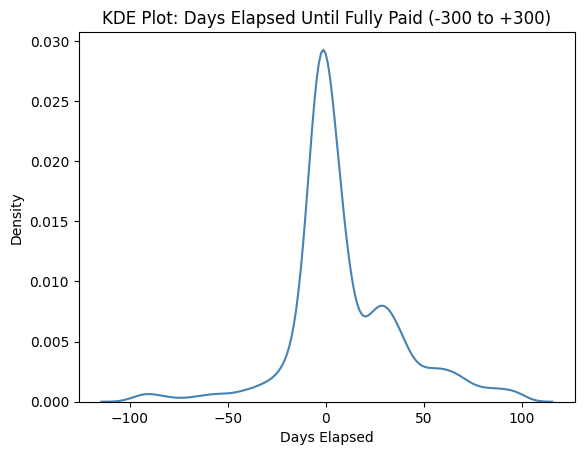

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Clean the column: drop NaNs and empty strings
cleaned_days = df_credit_sales['days_elapsed_until_fully_paid']
cleaned_days = cleaned_days.replace("", np.nan).dropna()

# Filter to range -300 to +300
filtered_days = cleaned_days[(cleaned_days >= -100) & (cleaned_days <= 100)]

# KDE plot
sns.kdeplot(
    x=filtered_days,
    fill=False,
    color="steelblue"
)

plt.title("KDE Plot: Days Elapsed Until Fully Paid (-300 to +300)")
plt.xlabel("Days Elapsed")
plt.ylabel("Density")
plt.show()

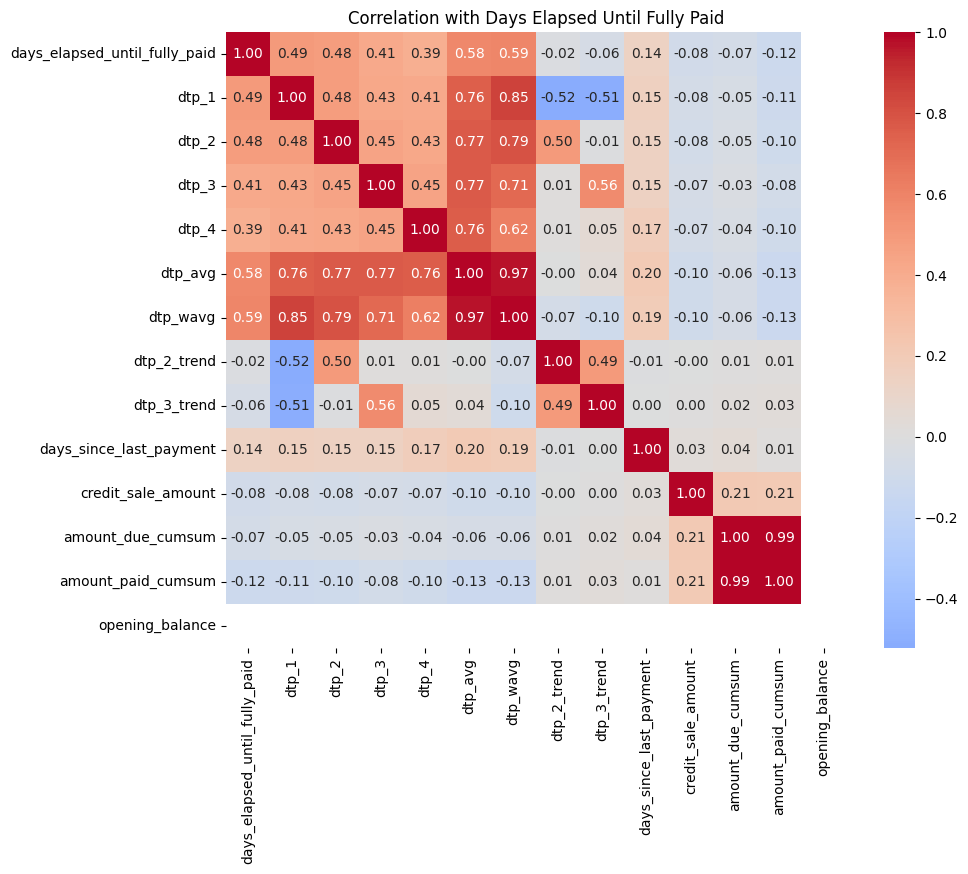

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

df_credit_sales = df_credit_sales.dropna(subset=['dtp_1', 'dtp_2', 'dtp_3', 'dtp_4'])

# Select relevant columns
cols = ['days_elapsed_until_fully_paid', 
        'dtp_1', 'dtp_2', 'dtp_3', 'dtp_4', 
        'dtp_avg', 'dtp_wavg', 'dtp_2_trend',
        'dtp_3_trend', 'days_since_last_payment',
        'credit_sale_amount', 'amount_due_cumsum',
        'amount_paid_cumsum', 'opening_balance']

# Compute correlation matrix
corr = df_credit_sales[cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation with Days Elapsed Until Fully Paid")
plt.show()

In [13]:
drop_columns = ['school_year', 'student_id_pseudonimized', 'category_name',
       'gross_receivables', 'amount_discounted', 'adjustments', 'date_fully_paid',
       'last_payment_date', 'days_elapsed_until_fully_paid',
       'plan_type_Plan - D', 'plan_type_Plan - E', 'plan_type_nan']

df_data = df_credit_sales.drop(columns=drop_columns)

# C. Machine Learning Pipelines

In [14]:
df_data.columns

Index(['credit_sale_amount', 'due_date', 'dtp_1', 'dtp_2', 'dtp_3', 'dtp_4',
       'dtp_avg', 'dtp_wavg', 'dtp_2_trend', 'dtp_3_trend',
       'days_since_last_payment', 'amount_due_cumsum', 'amount_paid_cumsum',
       'opening_balance', 'plan_type_Plan - A', 'plan_type_Plan - B',
       'plan_type_Plan - C', 'dtp_bracket'],
      dtype='object')

In [15]:
from MachineLearning.Utils.data_preparation import DataPreparer

# Initialize the preparer
preparer = DataPreparer(df_data, args.target_feature, test_size=args.test_size)

# Run preprocessing
preparer.prep_data()

# Load the train/test splits
X_train = preparer.X_train
X_test  = preparer.X_test
y_train = preparer.y_train
y_test  = preparer.y_test

c:\Users\rjbel\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Partitioning the datasets based on due_date...
Applying manual oversampling...


In [16]:
from MachineLearning import (
    AdaBoostPipeline,
    DecisionTreePipeline,
    GaussianNaiveBayesPipeline,
    KnearestNeighborPipeline,
    RandomForestPipeline,
    XGboostPipeline,
    MultiLayerPerceptronPipeline,
    TransformerPipeline,
)

models = {
    "ada_boost": AdaBoostPipeline,
    "decision_tree": DecisionTreePipeline,
    "gaussian_naive_bayes": GaussianNaiveBayesPipeline,
    "knn": KnearestNeighborPipeline,
    "random_forest": RandomForestPipeline,
    "xgboost": XGboostPipeline,
    "nn_mlp": MultiLayerPerceptronPipeline,
    #"nn_rnn": RecurrentNeuralNetworkPipeline,
    #"nn_transformer": TransformerPipeline
}

In [17]:
# To silence the error when running knn:
# UserWarning: Could not find the number of physical cores for the following reason:
# [WinError 2]
import os

os.environ['OMP_NUM_THREADS'] = '16'

In [18]:
import pandas as pd
from MachineLearning.Utils.load_parameters import ParameterLoader

# Load parameters from JSON
loader = ParameterLoader(args.parameters_dir)

all_results = []  # list to gather results

for model_name, pipeline_class in models.items():
    param_list = loader.get_parameters(model_name)

    for param in param_list:
        print(f"Running {model_name} with parameters: {param}")

        pipeline = pipeline_class(X_train, X_test, y_train, y_test,
                                  args,
                                  param)

        # Capture results from pipeline
        result = pipeline.build_model().train().evaluation().show_results()

        # Add metadata (model name + parameters)
        result["model"] = model_name
        result["parameters"] = str(param)

        all_results.append(result)

# Convert to DataFrame
results_df = pd.DataFrame(all_results)

# Export to Excel
results_df.to_excel("MachineLearning/Results/model_results.xlsx", index=False)
print("All results saved to model_results.xlsx")

Running ada_boost with parameters: {'learning_rate': 0.01, 'n_estimators': 50}
Running ada_boost with parameters: {'learning_rate': 0.01, 'n_estimators': 150}
Running ada_boost with parameters: {'learning_rate': 0.1, 'n_estimators': 50}
Running ada_boost with parameters: {'learning_rate': 0.1, 'n_estimators': 150}
Running ada_boost with parameters: {'learning_rate': 0.5, 'n_estimators': 50}
Running ada_boost with parameters: {'learning_rate': 1.0, 'n_estimators': 50}
Running ada_boost with parameters: {'learning_rate': 1.0, 'n_estimators': 150}
Running decision_tree with parameters: {'max_depth': 10, 'min_samples_leaf': 1}
Running decision_tree with parameters: {'max_depth': 10, 'min_samples_leaf': 3}
Running decision_tree with parameters: {'max_depth': 10, 'min_samples_leaf': 5}
Running decision_tree with parameters: {'max_depth': 20, 'min_samples_leaf': 1}
Running decision_tree with parameters: {'max_depth': 20, 'min_samples_leaf': 3}
Running decision_tree with parameters: {'max_dept

In [19]:
results_df.sort_values(by='f1_macro', ascending=False)

,accuracy,precision_macro,recall_macro,f1_macro,model,parameters
58,0.748292,0.642017,0.498181,0.503040,nn_mlp,"{'hidden_layer_sizes': [100], 'activation': 'r..."
3,0.541572,0.461602,0.468787,0.452087,ada_boost,"{'learning_rate': 0.1, 'n_estimators': 150}"
2,0.545558,0.461156,0.466983,0.445941,ada_boost,"{'learning_rate': 0.1, 'n_estimators': 50}"
5,0.558087,0.437294,0.477137,0.445781,ada_boost,"{'learning_rate': 1.0, 'n_estimators': 50}"
6,0.550114,0.431469,0.479710,0.439062,ada_boost,"{'learning_rate': 1.0, 'n_estimators': 150}"
...,...,...,...,...,...,...
14,0.429385,0.265587,0.288615,0.256408,gaussian_naive_bayes,{'var_smoothing': 0.001}
13,0.448178,0.280372,0.286239,0.241395,gaussian_naive_bayes,{'var_smoothing': 0.01}
60,0.283030,0.413323,0.322116,0.232642,nn_mlp,"{'hidden_layer_sizes': [300, 150, 50], 'activa..."
59,0.320615,0.344189,0.285639,0.188404,nn_mlp,"{'hidden_layer_sizes': [200, 100], 'activation..."
